## Introduction

In this project, we aim to develop a supervised machine learning algorithm to predict passenger survival on the Titanic using historical passenger data. The objective is to apply data analysis and machine learning techniques to build predictive models that can accurately determine the likelihood of survival based on various passenger attributes.

Firts of all we import the libraries necessary to process and visualize all the data:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
# Tools
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
# Models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Remove advertisings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category= RuntimeWarning)
warnings.simplefilter(action='ignore', category= UserWarning)

We now import the two different sets of data respectively to train and test the algorithm:

In [2]:
train = pd.read_csv("titanic_train.csv")
test = pd.read_csv("titanic_test.csv")

display(train.head())
display(test.head())

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,homedest
0,3,0,"Stoytcheff, Mr. Ilia",male,19,0,0,349205,7.8958,?,S,?,?,?
1,3,0,"Kink, Mr. Vincenz",male,26,2,0,315151,8.6625,?,S,?,?,?
2,3,0,"Sivic, Mr. Husein",male,40,0,0,349251,7.8958,?,S,?,?,?
3,2,1,"Brown, Miss. Edith Eileen",female,15,0,2,29750,39,?,S,14,?,"Cape Town, South Africa / Seattle, WA"
4,1,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",female,?,1,0,17453,89.1042,C92,C,5,?,"Paris, France / New York, NY"


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,homedest
0,3,0,"Nysveen, Mr. Johan Hansen",male,61,0,0,345364,6.2375,?,S,?,?,?
1,1,0,"Brandeis, Mr. Emil",male,48,0,0,PC 17591,50.4958,B10,C,?,208,"Omaha, NE"
2,2,0,"Giles, Mr. Ralph",male,24,0,0,248726,13.5000,?,S,?,297,"West Kensington, London"
3,3,0,"Risien, Mr. Samuel Beard",male,?,0,0,364498,14.5000,?,S,?,?,?
4,3,0,"Toufik, Mr. Nakli",male,?,0,0,2641,7.2292,?,C,?,?,?


# Data Preprocessing
## Data Cleaning
#### Label Encoding

In this code snippet, we perform data preprocessing by replacing placeholder missing values ('?') with -1 to handle null entries. We then apply feature encoding to transform categorical variables into numerical formats: converting 'sex' from 'male'/'female' to binary 0/1 and mapping 'embarked' ports to numerical codes. Finally, we attempt to normalize the 'homedest' feature by parsing and simplifying its values, but we decide to drop it because of too many unique values.

In [3]:
train.replace('?', -1, inplace=True)
test.replace('?', -1, inplace=True)

train['sex'] = train['sex'].replace({'male': 0, 'female': 1})
test['sex'] = test['sex'].replace({'male': 0, 'female': 1})

embarked = pd.concat([train['embarked'], test['embarked']]).unique()
print('Embarked:', len(embarked), embarked)

mapping = {'S': 0, 'C': 1, 'Q': 2}
train['embarked'] = train['embarked'].replace(mapping)
test['embarked'] = test['embarked'].replace(mapping)

# We try to shorten the homedest
homedest = pd.concat([train['homedest'], test['homedest']]).unique()
homedest = [val.split(',')[1].strip() if ',' in str(val) else val for val in homedest]
homedest = [val.split('/')[0].strip() if '/' in str(val) else val for val in homedest]
homedest = set(homedest)

print('Homedest:', len(homedest), homedest)
# There are so many unique values in homedest (149) for be representative, so its better to remove the feature.

Embarked: 4 ['S' 'C' 'Q' -1]
Homedest: 149 {'ON', 'Finland New York', 'NJ and', 'PA', 'DC', 'Ireland Charlestown', 'Cuba', 'IL', 'Glasgow', 'Finland Hoboken', 'Sweden Chicago', 'Hants', 'Sweden Huntley', 'DE', 'Uruguay', 'Utah', 'RI', 'AB', 'Devon', 'Italy', 'Liverpool', 'MI', 'OH', 'Austria-Hungary', 'Argentina', 'FL', 'Southampton', 'Sweden Minneapolis', 'Co Sligo', 'Yorks', 'Berkshire', 'England New York', 'Switzerland', 'Sweden Fower', 'MT', 'VA', 'Kent', 'England', 'Guernsey', 'NS', 'Ireland', 'WV', 'NE', 'Sweden Brooklyn', 'Avon', 'MA', 'WI', 'IA', 'Syria', 'ME', 'NH', 'KY', 'USA', 'Lancashire', 'Cornwall', 'Queens', 'England Wichita', 'Sweden Joliet', 'Ireland Sherbrooke', 'England Bedford', 'Ireland Washington', 'France', 'Belgium', 'MO', 'Norway Portland', 'Surrey', 'Japan', 'England Ohio', 'Chicago', 'Denmark', 'Ireland New York', 'Ireland Hartford', 'England Norfolk', 'Co Cork', 'Middlesex', 'Long Island', 'Thailand', 'Sweden New York', 'Staffs', 'Sweden Moune', 'Dorset', 'C

In [4]:
# Combine the train and test datasets for consistent processing
combine = [train, test]

# Extract titles from the 'name' column
for dataset in combine:
    dataset['Title'] = dataset['name'].str.extract(' ([A-Za-z]+)\\.', expand=False)

for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir',
                                                 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace(['Mlle', 'Ms'], 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}

for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

display(train.head())
display(test.head())


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,homedest,Title
0,3,0,"Stoytcheff, Mr. Ilia",0,19,0,0,349205,7.8958,-1,0,-1,-1,-1,1
1,3,0,"Kink, Mr. Vincenz",0,26,2,0,315151,8.6625,-1,0,-1,-1,-1,1
2,3,0,"Sivic, Mr. Husein",0,40,0,0,349251,7.8958,-1,0,-1,-1,-1,1
3,2,1,"Brown, Miss. Edith Eileen",1,15,0,2,29750,39,-1,0,14,-1,"Cape Town, South Africa / Seattle, WA",2
4,1,1,"Goldenberg, Mrs. Samuel L (Edwiga Grabowska)",1,-1,1,0,17453,89.1042,C92,1,5,-1,"Paris, France / New York, NY",3


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,homedest,Title
0,3,0,"Nysveen, Mr. Johan Hansen",0,61,0,0,345364,6.2375,-1,0,-1,-1,-1,1
1,1,0,"Brandeis, Mr. Emil",0,48,0,0,PC 17591,50.4958,B10,1,-1,208,"Omaha, NE",1
2,2,0,"Giles, Mr. Ralph",0,24,0,0,248726,13.5000,-1,0,-1,297,"West Kensington, London",1
3,3,0,"Risien, Mr. Samuel Beard",0,-1,0,0,364498,14.5000,-1,0,-1,-1,-1,1
4,3,0,"Toufik, Mr. Nakli",0,-1,0,0,2641,7.2292,-1,1,-1,-1,-1,1


We simplify the datasets by dropping the `homedest`, `name`, and `ticket` columns from both `train` and `test` Dataframe.

In [5]:
train = train.drop(columns=['homedest', 'name', 'ticket'])
test = test.drop(columns=['homedest', 'name', 'ticket'])

display(train.head())
display(test.head())

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,boat,body,Title
0,3,0,0,19,0,0,7.8958,-1,0,-1,-1,1
1,3,0,0,26,2,0,8.6625,-1,0,-1,-1,1
2,3,0,0,40,0,0,7.8958,-1,0,-1,-1,1
3,2,1,1,15,0,2,39,-1,0,14,-1,2
4,1,1,1,-1,1,0,89.1042,C92,1,5,-1,3


,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,boat,body,Title
0,3,0,0,61,0,0,6.2375,-1,0,-1,-1,1
1,1,0,0,48,0,0,50.4958,B10,1,-1,208,1
2,2,0,0,24,0,0,13.5000,-1,0,-1,297,1
3,3,0,0,-1,0,0,14.5000,-1,0,-1,-1,1
4,3,0,0,-1,0,0,7.2292,-1,1,-1,-1,1


### Columns treatment

We are assessing data quality by calculating the number and percentage of placeholder '-1' values in each column of the `train` and `test` datasets to identify missing or invalid entries. This analysis helps us determine which features may require imputation or removal before proceeding with model training.

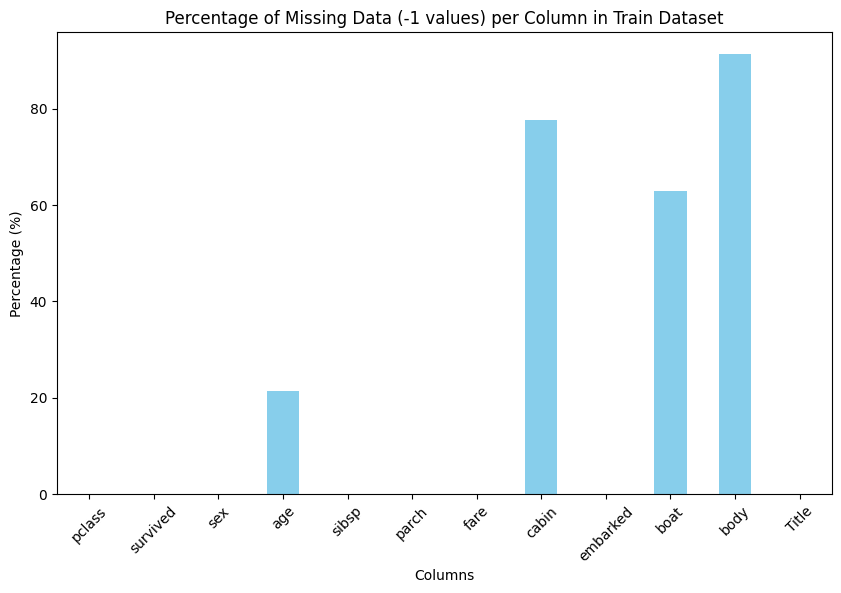

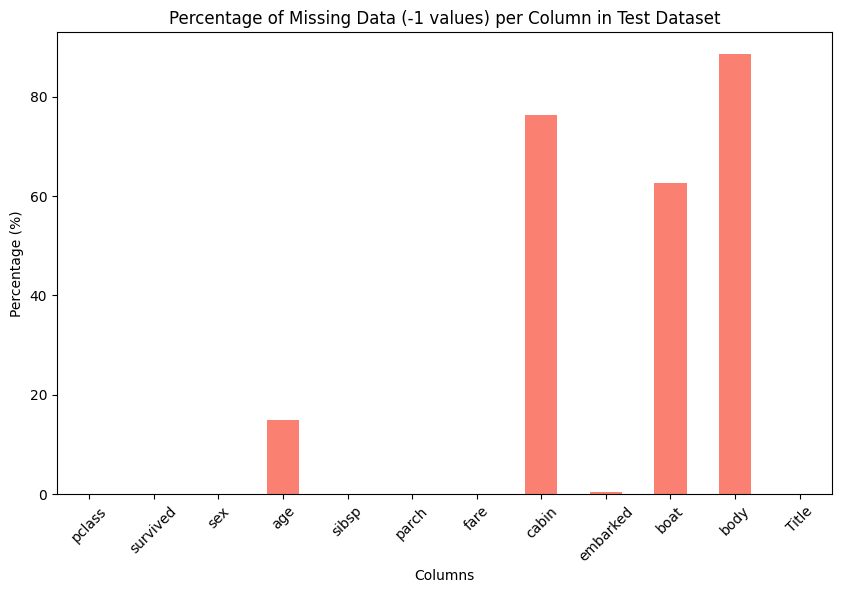

In [6]:

# Counting the number of -1 values in each column for train and test datasets
count_missing_train = (train == -1).sum()
count_missing_test = (test == -1).sum()

# Calculate the percentage of -1 values in each column
percentage_missing_train = (count_missing_train / len(train)) * 100
percentage_missing_test = (count_missing_test / len(test)) * 100

# Plotting the percentage of missing data for each column in the train dataset
plt.figure(figsize=(10, 6))
percentage_missing_train.plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Data (-1 values) per Column in Train Dataset')
plt.ylabel('Percentage (%)')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.show()

# Plotting the percentage of missing data for each column in the test dataset
plt.figure(figsize=(10, 6))
percentage_missing_test.plot(kind='bar', color='salmon')
plt.title('Percentage of Missing Data (-1 values) per Column in Test Dataset')
plt.ylabel('Percentage (%)')
plt.xlabel('Columns')
plt.xticks(rotation=45)
plt.show()


#### Cabin, Boat and Body
We are creating new binary features `has_boat` and `body_found` by converting the multiclass `boat` and `body` columns into binary indicators to reflect whether a passenger had access to a lifeboat or if their body was recovered both crucial for predicting survival. Afterwards, we drop the original `cabin`, `boat`, and `body` columns from the datasets to streamline the data and eliminate less informative or redundant features.

In [7]:
# Function that converts a multiclass feature into a binary feature
def binary_feature(value):
    if value == -1 or value == 0:
        return 0
    else:
        return 1

train['has_boat'] = train['boat'].apply(binary_feature)
test['has_boat'] = test['boat'].apply(binary_feature)
train['body_found'] = train['body'].apply(binary_feature)
test['body_found'] = test['body'].apply(binary_feature)

train = train.drop(columns=['cabin', 'boat', 'body'])
test = test.drop(columns=['cabin', 'boat', 'body'])

display(train.head())
display(test.head())

,pclass,survived,sex,age,sibsp,parch,fare,embarked,Title,has_boat,body_found
0,3,0,0,19,0,0,7.8958,0,1,0,0
1,3,0,0,26,2,0,8.6625,0,1,0,0
2,3,0,0,40,0,0,7.8958,0,1,0,0
3,2,1,1,15,0,2,39,0,2,1,0
4,1,1,1,-1,1,0,89.1042,1,3,1,0


,pclass,survived,sex,age,sibsp,parch,fare,embarked,Title,has_boat,body_found
0,3,0,0,61,0,0,6.2375,0,1,0,0
1,1,0,0,48,0,0,50.4958,1,1,0,1
2,2,0,0,24,0,0,13.5000,0,1,0,1
3,3,0,0,-1,0,0,14.5000,0,1,0,0
4,3,0,0,-1,0,0,7.2292,1,1,0,0


### Scaling
We are standardizing the numerical features by scaling each column's values excluding the placeholder '-1' entries to ensure that all features contribute equally during model training. Scaling is important because it normalizes the feature ranges, which improves the performance of many machine learning algorithms by enhancing convergence and preventing features with larger scales from dominating the learning process.

In [8]:
def data_scaler(data, scaler): # scaler = MinMaxScaler(), StandardScaler(), RobustScaler(), ...
    data_scaled = data.copy()

    for column in data.columns:
        mask = data[column] != -1
        data_scaled.loc[mask, column] = scaler.fit_transform(data.loc[mask, [column]])
        
    return data_scaled

### Feature Distribution
We include a graph that shows how the numeric features are distributed.

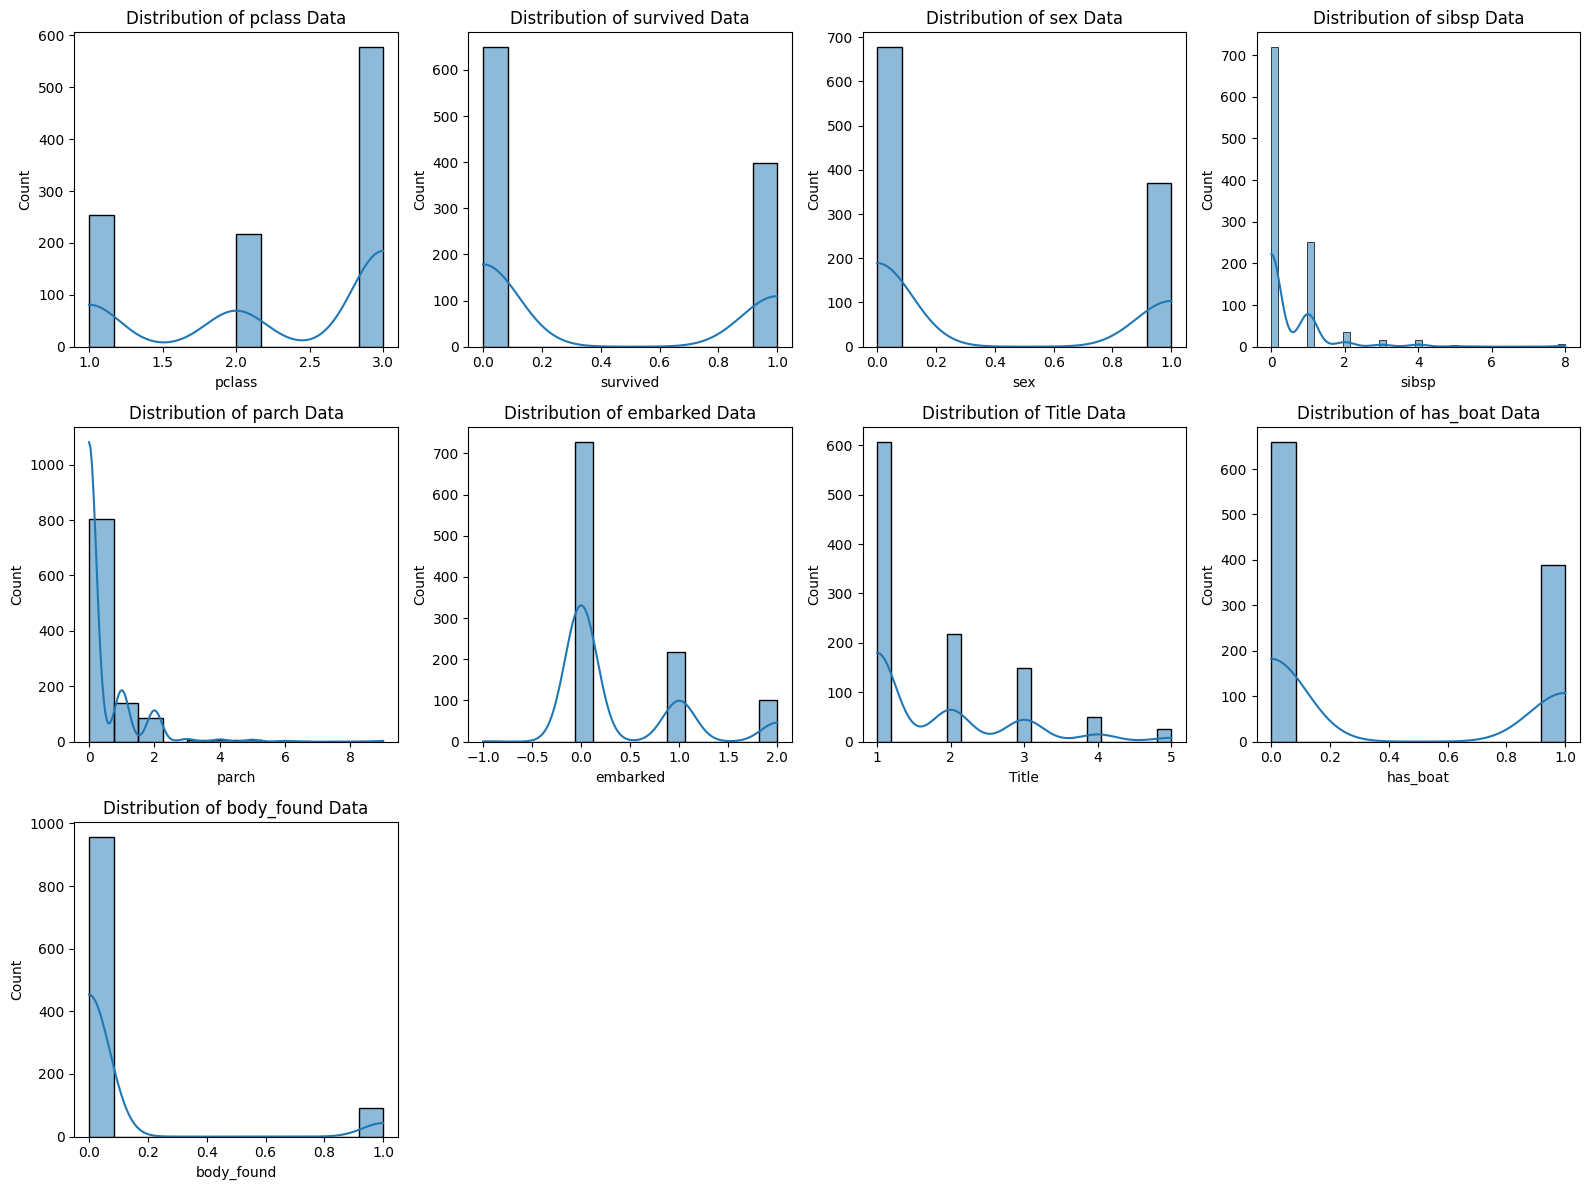

In [9]:
# Filter only the numeric columns
numeric_cols = train.select_dtypes(include=['number']).columns
num_plots = min(len(numeric_cols), 16)  
rows = num_plots // 4 + (num_plots % 4 > 0)  

plt.figure(figsize=(16, rows * 4))

for i, col in enumerate(numeric_cols[:num_plots], 1):  
    plt.subplot(rows, 4, i)
    sns.histplot(train[col], kde=True)
    plt.title(f"Distribution of {col} Data")
    plt.tight_layout()

plt.show()

### Correlation Matrix
We can include a feature correlation graph to visualize the relationships between variables in the dataset.

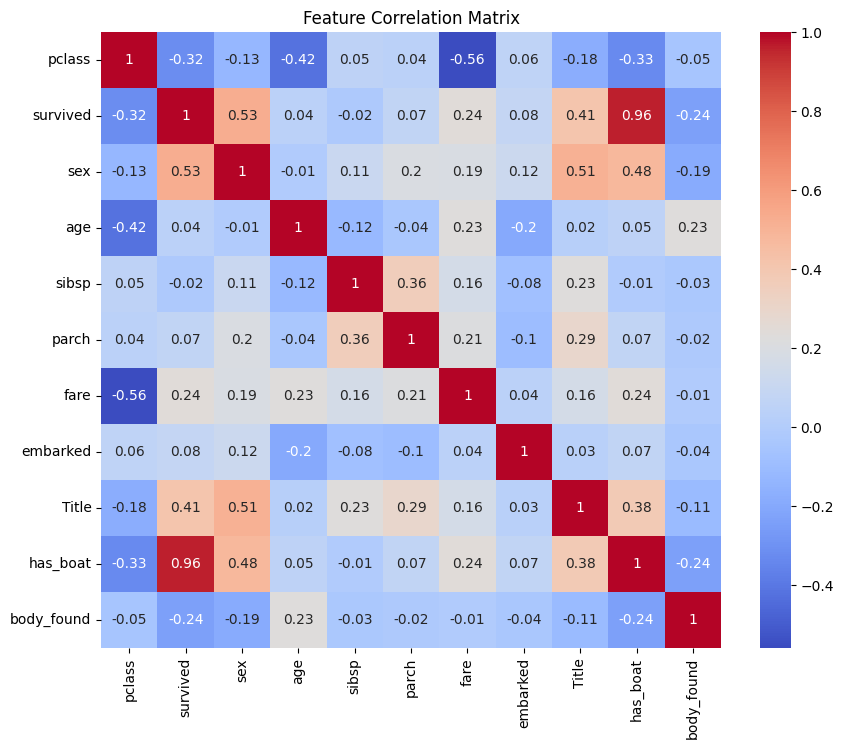

In [10]:
correlation_matrix = train.corr().round(2)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

We remove the features that are weakly correlated with the classification column: `survived`

In [11]:
train = train.drop(columns=['age', 'sibsp'])
test = test.drop(columns=['age', 'sibsp'])

# Supervised Learning

In [12]:
# Scaling
train = data_scaler(train, MinMaxScaler())
test = data_scaler(test, MinMaxScaler())

In [13]:
train = train.sample(frac=1, random_state=42).reset_index(drop=True)
test = test.sample(frac=1, random_state=42).reset_index(drop=True)

X_train = train.drop(columns=['survived'])
y_train = train["survived"]

X_test = test.drop(columns=['survived'])
y_test = test["survived"]

display(X_train.head())
display(y_train.head())
display(X_test.head())
display(y_test.head())

# Merge the datasets for cross validation
X = pd.concat([X_train, X_test], ignore_index=True)
y = pd.concat([y_train, y_test], ignore_index=True)

,pclass,sex,parch,fare,embarked,Title,has_boat,body_found
0,1.0,0,0.222222,0.045771,0.0,0.00,0,0
1,0.5,0,0.000000,0.025374,0.0,0.00,0,1
2,0.0,1,0.000000,0.053571,0.5,0.50,1,0
3,1.0,1,0.000000,0.015127,1.0,0.25,1,0
4,1.0,0,0.000000,0.014151,0.0,0.00,0,0


0    0
1    0
2    1
3    1
4    0
Name: survived, dtype: int64

,pclass,sex,parch,fare,embarked,Title,has_boat,body_found
0,0.0,1,0.4,0.513342,0.0,0.25,1,0
1,1.0,0,0.0,0.016892,0.0,0.00,0,1
2,1.0,0,0.0,0.014102,0.5,0.00,0,0
3,0.5,0,0.0,0.025374,0.0,0.00,0,0
4,1.0,0,0.0,0.015469,0.0,0.00,0,0


0    1
1    0
2    0
3    0
4    0
Name: survived, dtype: int64

#### Functions

In [14]:
# Function that applies a model to the dataset
def training_model(model, params, n_iter=10):
    
    # Hyperparameters tunning
    model_random_search = RandomizedSearchCV(model, params, n_iter=n_iter, cv=5, n_jobs=-1, verbose=0, random_state=42)
    model_random_search.fit(X_train, y_train)

    # Best hyperparameter
    print(f"Best hyperparameters: {model_random_search.best_params_}")
    best_model = model_random_search.best_estimator_

    y_pred_model = best_model.predict(X_test)
    model_accuracy = accuracy_score(y_test, y_pred_model)
    print("Random Forest Best Accuracy:", model_accuracy)

    # Cross Validation
    cv_model_scores = cross_val_score(best_model, X, y, cv=5)
    cv_model_mean = np.mean(cv_model_scores)
    print(f"Cross Validation mean accuracy: {cv_model_mean}")

    return cv_model_mean, best_model, y_pred_model

In [15]:
# Function that calculates metrics
def metricas(pred):
    precision = metrics.precision_score(y_test, pred)
    recall = metrics.recall_score(y_test, pred)
    f1 = metrics.f1_score(y_test, pred)
    auc_roc = metrics.roc_auc_score(y_test, pred)
    conf_matrix = metrics.confusion_matrix(y_test, pred)

    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC-ROC: {auc_roc}")

    # Plot the confusion matrix
    plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
    plt.colorbar()
    plt.xticks([0, 1], ['Negative', 'Positive'])
    plt.yticks([0, 1], ['Negative', 'Positive'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')

    # Add labels to the plot
    class_names = ['TN', 'FP', 'FN', 'TP']
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, f"{class_names[i*2 + j]} = {conf_matrix[i, j]}",
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

    plt.show()

In [16]:
# Learning curve
def learning_c(model, X, y, sizes=np.linspace(0.2, 1.0, 8)):
    train_sizes, train_scores, val_scores = learning_curve(model, X, y, train_sizes=sizes, cv=3)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure()
    plt.title("Learning Curves")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Validation Score")

    plt.legend(loc="best")
    plt.show()

In [17]:
# Validation curve
def validation_c(model, X, y, name, range):
    train_scores, val_scores = validation_curve(model, X, y, param_name=name, param_range=range, cv=5)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure()
    plt.title("Validation Curves")
    plt.xlabel(name)
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(range, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")

    plt.plot(range, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(range, val_scores_mean, 'o-', color="g", label="Validation Score")

    plt.legend(loc="best")
    plt.show()

## Random Forest
This model tries to classify the dataset creating multiple decision trees that are trained with different samples and feaatures. This prevents overfitting, as each tree has learned differently and given different weights to the variables.

Each tree makes its own prediction about the answer and Random Forest combines the predictions, choosing the class with most votes.

In [18]:
arr = np.arange(5, 22, 2)

rf_params = {
    'n_estimators': np.arange(20, 220, 20),
    'max_depth': np.append(arr, None),
    'min_samples_split': np.arange(2, 11)
}

random_forest = RandomForestClassifier(random_state=42)
cv_rf_mean, best_rf, y_pred_rf = training_model(random_forest, rf_params)

Best hyperparameters: {'n_estimators': np.int64(20), 'min_samples_split': np.int64(9), 'max_depth': 5}
Random Forest Best Accuracy: 0.9618320610687023
Cross Validation mean accuracy: 0.9763066303998128


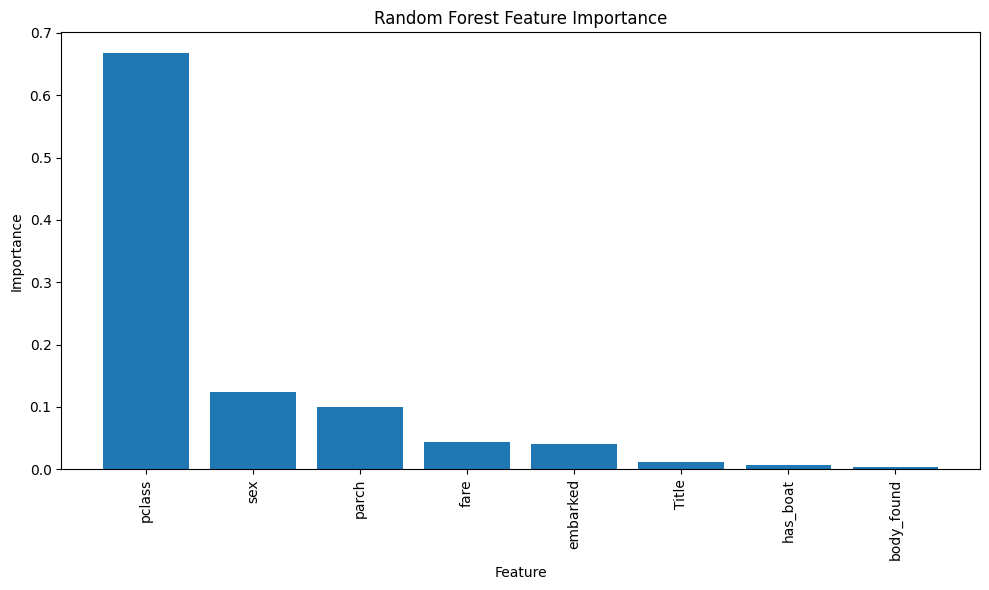

Precision: 0.9693877551020408
Recall: 0.9313725490196079
F1 Score: 0.95
AUC-ROC: 0.9563112745098039


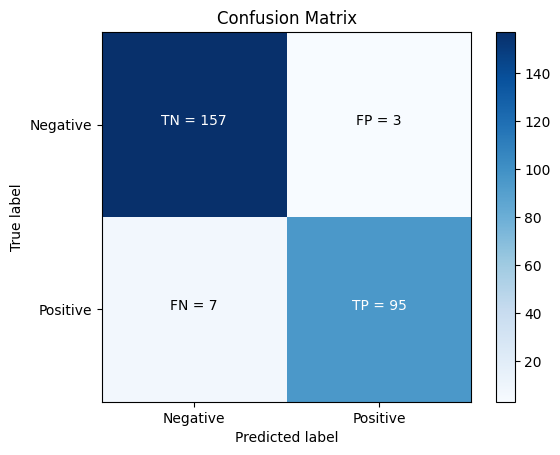

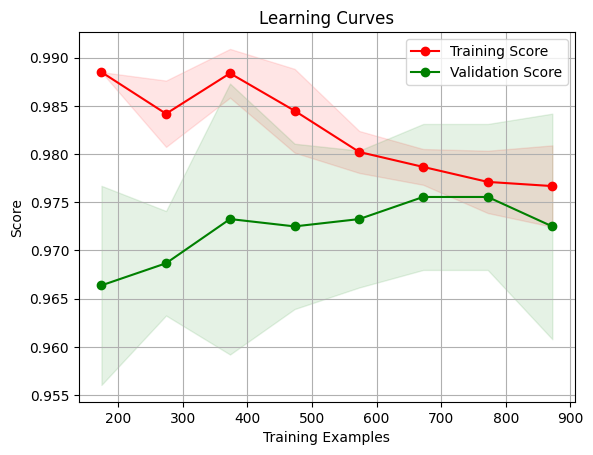

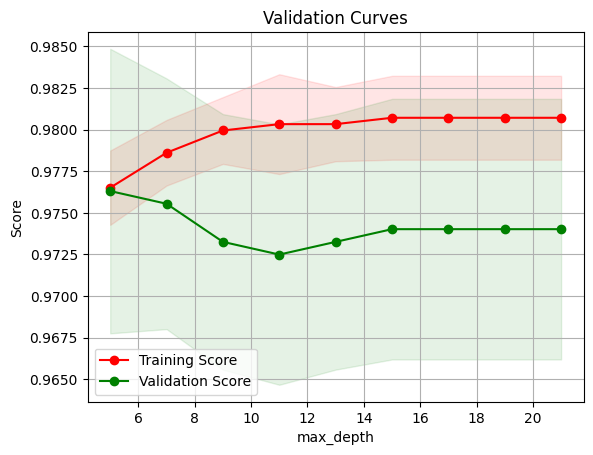

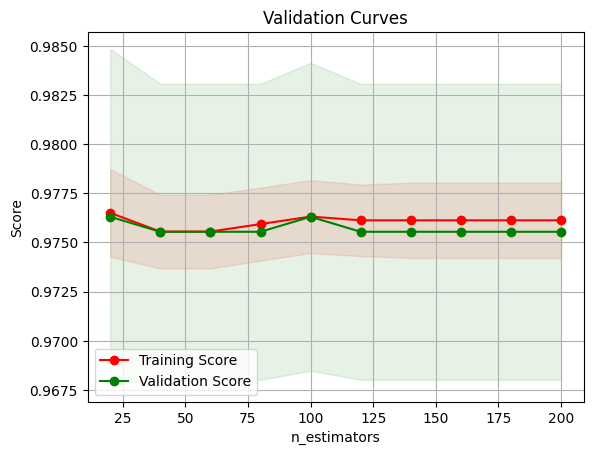

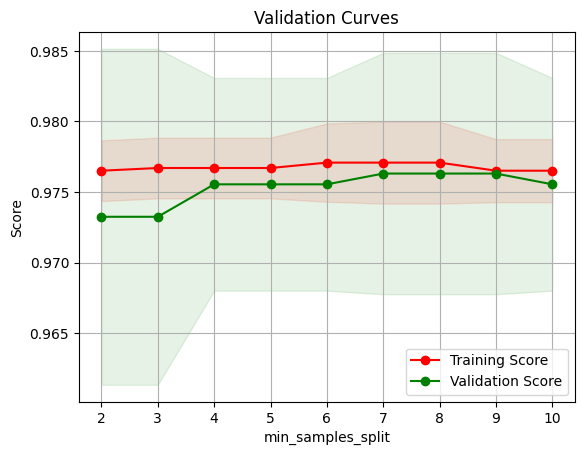

In [19]:
# Get the feature importances
feature_importances = best_rf.feature_importances_

# Sort the feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_importances = feature_importances[sorted_indices]
sorted_features = X.columns

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), sorted_importances, tick_label=sorted_features)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

metricas(y_pred_rf)
learning_c(best_rf, X, y)
validation_c(best_rf, X, y, 'max_depth', np.arange(5, 22, 2))
validation_c(best_rf, X, y, 'n_estimators', np.arange(20, 220, 20))
validation_c(best_rf, X, y, 'min_samples_split', np.arange(2, 11))

### AdaBoost

We will try to improve the accuracy of the model with the use of boosting algorithms. This model has the same conceptual basis as Random Forest, since it uses several decision trees to make a combined prediction.

The difference in this model is the way of contrasting the predictions of these trees. After training the first tree, AdaBoost evaluates the errors it makes. Then, it assigns a higher weight to the samples it misclassified, making the next tree pay special attention to these difficult cases. This process is repeated, creating a "chain" of trees, where each one corrects the errors of its predecessor.

Best hyperparameters: {'n_estimators': np.int64(40)}
Random Forest Best Accuracy: 0.9618320610687023
Cross Validation mean accuracy: 0.9763066303998128
Precision: 0.9693877551020408
Recall: 0.9313725490196079
F1 Score: 0.95
AUC-ROC: 0.9563112745098039


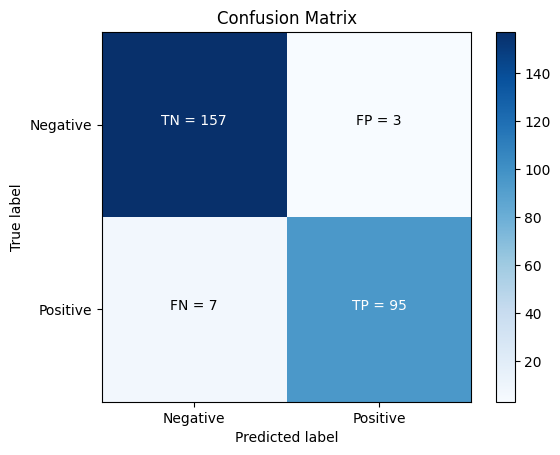

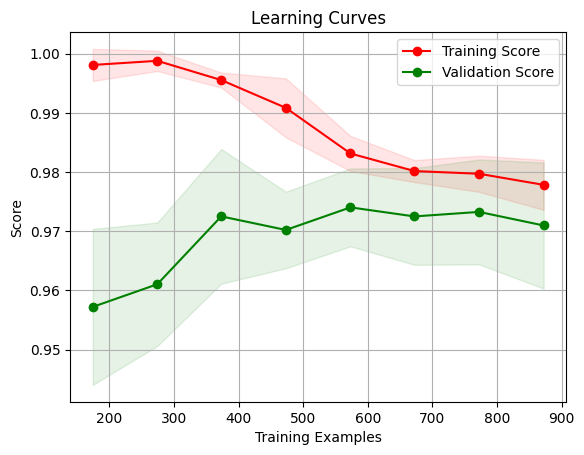

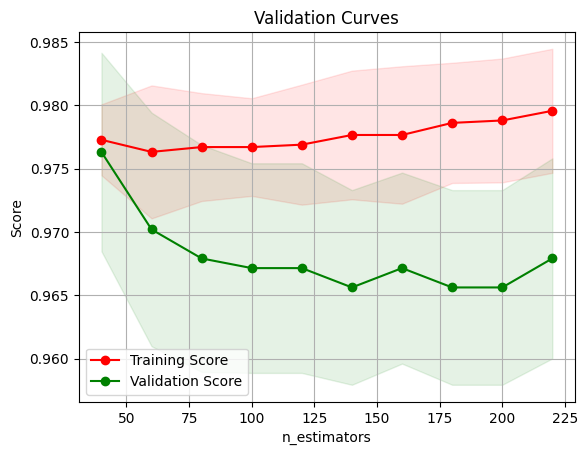

In [20]:
ada_params = {'n_estimators': np.arange(40, 240, 20)}

ada_clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), random_state=42)
cv_ada_mean, best_ada, y_pred_ada = training_model(ada_clf, ada_params, n_iter=5)

metricas(y_pred_ada)
learning_c(best_ada, X, y)
validation_c(best_ada, X, y, 'n_estimators', np.arange(40, 240, 20))

### Gradient Boosting
This model differs from AdaBoost in that it gives more importance to errors, calculated as the probability of incorrect classification.

The predictions from this new tree are added to the current model to improve the total accuracy. Each successive tree is trained to reduce the residual errors of the accumulated model.

Best hyperparameters: {'n_estimators': np.int64(40)}
Random Forest Best Accuracy: 0.9618320610687023
Cross Validation mean accuracy: 0.9747799128425608
Precision: 0.9693877551020408
Recall: 0.9313725490196079
F1 Score: 0.95
AUC-ROC: 0.9563112745098039


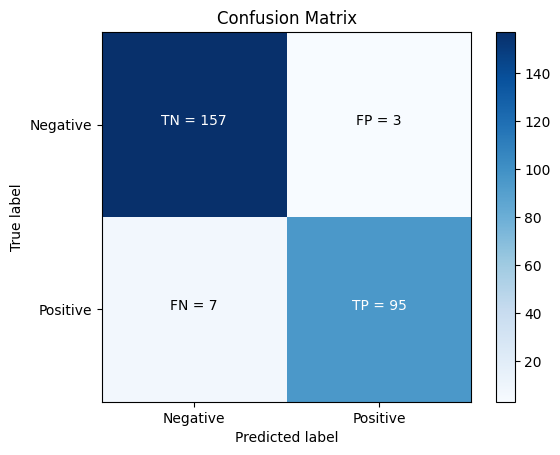

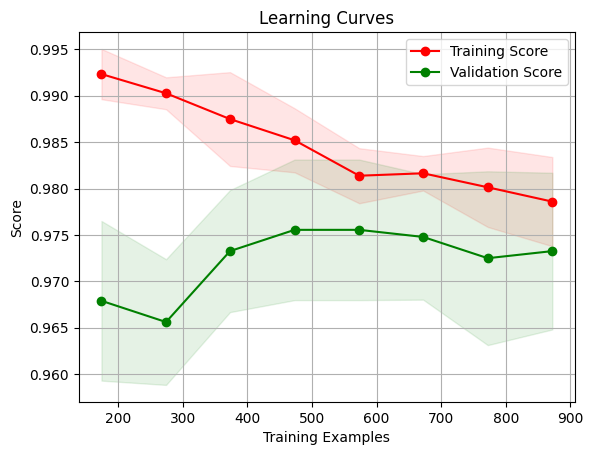

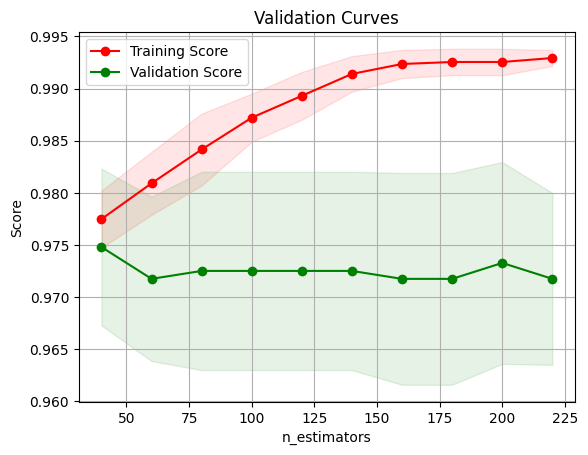

In [21]:
gb_clf = GradientBoostingClassifier(random_state=42)
cv_gb_mean, best_gb, y_pred_gb = training_model(gb_clf, ada_params)

metricas(y_pred_gb)
learning_c(best_gb, X, y)
validation_c(best_gb, X, y, 'n_estimators', np.arange(40, 240, 20))

## Neural Network
Neural networks are machine learning models inspired by the functioning of the human brain. The neural network recieves the inicial data (initial layer), do transformations to learn complex features (hidden layers), and then make the prediction (final layer).

Between iterations, the model applies an activation function that allows the network to learn more complex relations between samples. For the last step, the model do a backward propagation to adjust the features' weights with the relations learned.

MLP Classifier is more simple tahn others Neural Networks, but works better with classification in structured data.

Best hyperparameters: {'solver': 'sgd', 'hidden_layer_sizes': (50, 50), 'alpha': 0.001, 'activation': 'tanh'}
Random Forest Best Accuracy: 0.9618320610687023
Cross Validation mean accuracy: 0.9755432716211867
Precision: 0.9693877551020408
Recall: 0.9313725490196079
F1 Score: 0.95
AUC-ROC: 0.9563112745098039


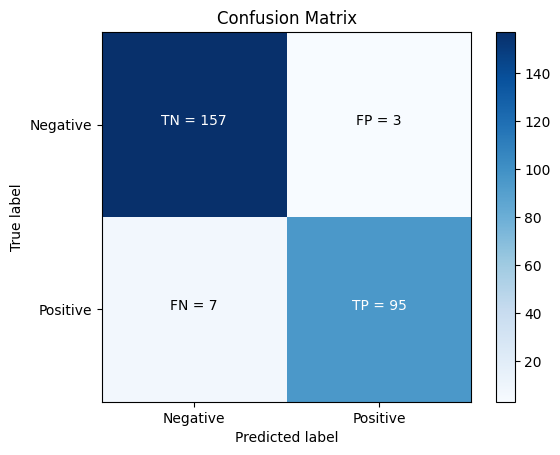

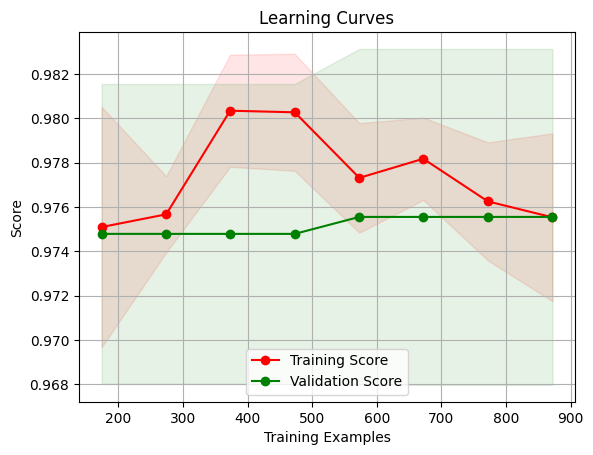

In [22]:
mlp_params = {
    'hidden_layer_sizes': [(50, 0), (100, 0), (50, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01]
}

mlp = MLPClassifier(max_iter=1000, random_state=42)
cv_mlp_mean, best_mlp, y_pred_mlp = training_model(mlp, mlp_params)

metricas(y_pred_mlp)
learning_c(best_mlp, X, y)

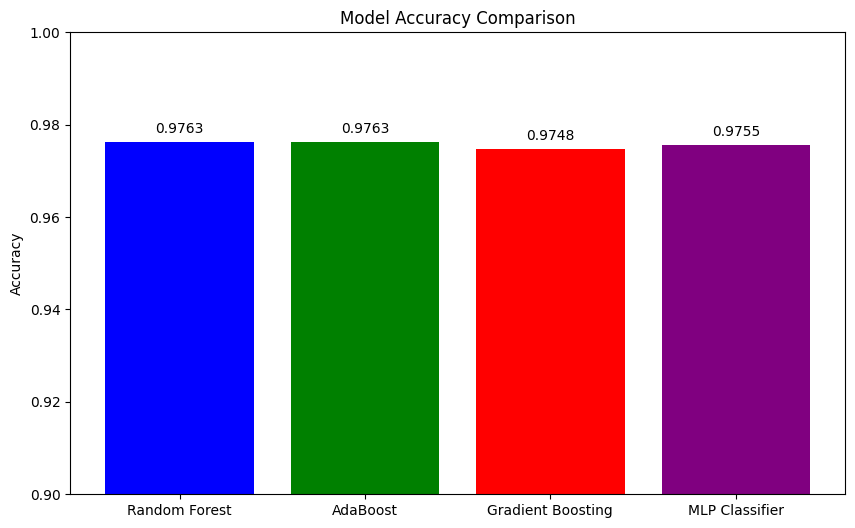

In [23]:
# Compare results
models = ['Random Forest', 'AdaBoost', 'Gradient Boosting', 'MLP Classifier']
accuracies = [cv_rf_mean, cv_ada_mean, cv_gb_mean, cv_mlp_mean]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])

# Add values on top of each bar
for i in range(len(models)):
    plt.text(i, accuracies[i] + 0.002, f'{accuracies[i]:.4f}', ha='center', fontsize=10)

plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0.90, 1)
plt.show()

## Results
Contrasting the models' accuracy after Random Searching with the sweet spots of the validation curves, we canclude that the best models are:

Random Forest (n_estimators = 20, max_depth = 5, min_samples_split = 7) = 0.9763

Ada Boost (n_estimator = 40) = 0.9763